In [6]:
# Import libraries, set some settings

# Useful libraries
import pandas as pd
import numpy as np
import pickle
import random

# Modelling and Metrics
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (confusion_matrix, accuracy_score, roc_curve, roc_auc_score, precision_recall_curve,
                             f1_score, auc, average_precision_score, matthews_corrcoef)
from sklearn.utils import resample

# Black box
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import (LinearDiscriminantAnalysis,
                                           QuadraticDiscriminantAnalysis)
from sklearn.linear_model import LogisticRegression

# Visualise
import matplotlib.pyplot as plt
import seaborn as sns

# Settings for the notebook
pd.options.display.max_columns = None

# Get rid of annoying stuff
import warnings
warnings.simplefilter('ignore')

In [2]:
class ModelMetrics():
    """
        ModelMetrics class that will provide many different metrics for a given model outputs. 

        Required Parameters:
        y_test = Test Data Classes. Should be either (-1,1) or (0,1).
        y_pred = Predictions for the "probability" of y being in the positive class. Should be in range (-inf,inf)
        y_prob = Test Data Predictions from the model. Should be same format as y_test. 

        Useful functions:
        all_metrics() = returns metrics including: class imbalance, 
                                                   accuracy,
                                                   confusion matrix,
                                                   ROC/AUC,
                                                   Precision/Recall Curve, F1 score, MCC, AUC, Average Precision
        
    """
    
    def __init__(self,y_test,y_pred,y_prob):
        self.y_test = np.array(y_test).reshape(-1)
        self.y_pred = np.array(y_pred).reshape(-1)
        self.y_prob = np.array(y_prob).reshape(-1)
        
    def all_metrics(self):
        print('')
        self.imbalance()
        print('')
        self.accuracy()
        print('')
        self.print_cm()
        print('')
        self.roc_metrics()
        print('')
        self.pr_metrics()
        
    def roc_metrics(self):
        self.roc_plot()
        self.print_auc_roc()
        
    def pr_metrics(self):
        self.plot_pr()
        self.print_f1()
        self.print_mcc()
        self.print_auc_pr()
        self.print_ap()
        
    # Measure Imbalance
    def imbalance(self):
        num_examples = len(self.y_test)
        num_neg = np.sum(self.y_test==-1)
        num_pos = np.sum(self.y_test==+1)
        print("Number of -1 cases = ",num_neg)
        print("Number of +1 cases = ",num_pos)
        print('The ratio of Positve to Negative cases is {:0.3f}'.format(num_pos/num_neg))
        
        print('')
        if num_neg/num_pos >= 2:
            print('Number of Negative Classes is quite large. Recommend using the Precision-Recall Metrics.')
        elif num_pos/num_neg >=2:
            print('Number of Positive Classes is quite large. Recommend using the Precision-Recall Metrics.')
        else:
            print('The classes seem balanced. ROC metrics should be acceptable.')
        print('')
    
    # Overall accuracy
    def accuracy(self):
        acc = accuracy_score(self.y_test,self.y_pred)
        print('Overall Accuracy = {:0.3f}'.format(acc))
        return acc
        
    # Confusion Matrix
    def print_cm(self):
        cm = confusion_matrix(self.y_test,self.y_pred)
        true_negative, false_positive, false_negative, true_positive = cm.ravel()
        print('           CONFUSION MATRIX')
        print('                 y_pred')
        print('          {:^10d}{:^10d}'.format(-1,1))
        print('           --------------------')
        print('y_test -1 |{:^10d}{:^10d}|'.format(true_negative,false_positive))
        print('        1 |{:^10d}{:^10d}|'.format(false_negative,true_positive))
        print('           --------------------')
        return cm
        
    # ROC Curve
    def roc_plot(self):
        false_positive_rate, true_positive_rate, thresholds = roc_curve(self.y_test,self.y_prob)
        plt.plot(false_positive_rate,true_positive_rate,'-b',label='Model')
        plt.plot([0,1],[0,1],'-k',label='Guess')
        plt.title('ROC Curve')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.xlim([-0.02,1.0])
        plt.ylim([0.0,1.02])
        plt.legend()
        plt.show()

    # AUC of ROC
    def print_auc_roc(self):
        auc1 = roc_auc_score(self.y_test,self.y_prob)
        print('AUC = {:0.3f}'.format(auc1))
        return auc1

    ## These next few are more useful for imbalanced classes 

    # Precision - Recall Curve
    def plot_pr(self):
        precision, recall, thresholds = precision_recall_curve(self.y_test, self.y_prob)
        plt.plot(recall,precision,'-b',label='Model')
        plt.plot([0,1],[0.5,0.5],'-k',label='Guess')
        plt.title('Precision-Recall Curve')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.xlim([-0.02,1.0])
        plt.ylim([0.0,1.02])
        plt.legend()
        plt.show()

    # F1 Score
    def print_f1(self):
        f1 = f1_score(self.y_test,self.y_pred)
        print("F1 Score = {:0.3f}".format(f1))
        return f1
    
    # Matthews Correlation
    def print_mcc(self):
        mcc = matthews_corrcoef(self.y_test,self.y_pred)
        print("MCC = {:0.3f}".format(mcc))
        return mcc

    # AUC for PR
    def print_auc_pr(self):
        precision, recall, thresholds = precision_recall_curve(self.y_test, self.y_prob)
        auc2 = auc(recall,precision)
        print("AUC for Precision-Recall: {:0.3f}".format(auc2))
        return auc2

    # Average precision
    def print_ap(self):
        average_precision = average_precision_score(self.y_test,self.y_prob)
        print("Average Precision = {:0.3f}".format(average_precision))
        return average_precision

In [3]:
# Read in all three sets of data, (make sure they are same length)
# Create DF 

# Important Values
n_signal = 36499
n_bkgd = 93565
n_features = 50

# Read in all the data 
data = pd.read_csv('../Data/MiniBooNE_PID.txt', sep='\s+', skiprows=1,header=None)
pd.options.display.max_columns = None

# Scale and append signal/background cases
scaler = StandardScaler()
data = data[data>-999] # Get rid of bad data, set to NA
scaler.fit(data)
data = pd.DataFrame(scaler.transform(data))

data_sig = data.iloc[0:n_signal,:]
data_sig.dropna(inplace=True)

data_bkgd = data.iloc[n_signal:,:]
#data_bkgd = data_bkgd[data_bkgd>-999]
data_bkgd.dropna(inplace=True)

# Add a column of 1s for signal and 0s for background
n_sig_new = data_sig.shape[0]
n_bkgd_new = data_bkgd.shape[0]
data_sig = data_sig.assign(target=np.ones((n_sig_new,1)))
data_bkgd = data_bkgd.assign(target=-np.ones((n_bkgd_new,1)))
data_full = data_sig.append(data_bkgd)

df_svm = data_full.copy()
df_svm.dropna(inplace=True)

df_rf = data_full.copy()
df_rf.dropna(inplace=True)

df_lda = data_full.copy()
df_lda.dropna(inplace=True)

n_examples = df_svm.shape[0]
n_index = np.arange(n_examples)

C:\Users\linds\Anaconda3\envs\datascience\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\linds\Anaconda3\envs\datascience\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [4]:
# Split into x and y datasets, scale the x data
scaler = StandardScaler()

# Use the svm classes, as the actual value of the class is important here
y_all = df_svm['target'].values

# For SVM, columns 1 to 72 are predictors, 73 is next bus bunching
x_svm = df_svm.drop(['target'],axis=1).values
x_svm = scaler.fit_transform(x_svm)

# For RF
x_rf = df_rf.drop(['target'],axis=1).values
x_rf = scaler.fit_transform(x_rf)

# For LDA
x_lda = df_lda.drop(['target'],axis=1).values
x_lda = scaler.fit_transform(x_lda)

In [5]:
# Further split the data into training and testing datasets
# Training data will be used with k-folds to determine level one data
# Will end up with k versions of each model
n_train_index, n_test_index = train_test_split(n_index, test_size = 0.1)

y_train = y_all[n_train_index]
y_test = y_all[n_test_index]

x_train_svm = x_svm[n_train_index,:]
x_test_svm = x_svm[n_test_index,:]

x_train_rf = x_rf[n_train_index,:]
x_test_rf = x_rf[n_test_index,:]

x_train_lda = x_lda[n_train_index,:]
x_test_lda = x_lda[n_test_index,:]

In [ ]:
# Hyperparameters
# SVM
C = 10 #[0.1,1,10]
C_list = [0.1,0.3,1,3,10]
gamma = 0.1 #[0.1,0.3,1,3,10]
max_iter = 5000
gamma_list = [0.1,0.3,1,3,10]

# RF
criterion='entropy'
max_depth=9 #range(1,11)
max_depth_list = np.arange(1,11)
n_estimators=100 #[10,50,100]
n_estimators_list = [10,50,100]
min_samples_split=2 #[2,5,10,20]
min_samples_split_list = [2,5,10,20]

# LDA / QDA

# Do k folds to determine level 1 data, 
n_models = 3
n_splits = 20
models_svm = []
models_rf = []
models_lda = []
x_level_1 = np.empty((n_train_index.shape[0],n_models*n_splits))
y_level_1 = np.empty(n_train_index.shape)
y_level_1 = y_train

kf = KFold(n_splits=n_splits,shuffle=True)
fold_count = 0
for ktrain_index, ktest_index in kf.split(y_train):
    print("\nStarting Fold ",fold_count)
    x_train_svm_k, x_test_svm_k = x_train_svm[ktrain_index], x_train_svm[ktest_index]
    x_train_rf_k, x_test_rf_k = x_train_rf[ktrain_index], x_train_rf[ktest_index]
    x_train_lda_k, x_test_lda_k = x_train_lda[ktrain_index], x_train_lda[ktest_index]
    y_train_k, y_test_k = y_train[ktrain_index], y_train[ktest_index]
    
    # Assign random values to hyperparameters?
    C = random.choice(C_list)
    gamma = random.choice(gamma_list)
    max_depth = random.choice(max_depth_list)
    n_estimators = random.choice(n_estimators_list)
    min_samples_split = random.choice(min_samples_split_list)
    
    # Train SVM model k
    model_svm = SVC(C = C, gamma = gamma, max_iter = max_iter, probability = True)
    model_svm.fit(x_train_svm_k,y_train_k)
    #x_svm_1 = model_svm.predict(x_test_svm_k)
    x_svm_1 = model_svm.predict_proba(x_train_svm)[:,1]
    x_level_1[:,n_models*fold_count+0] = x_svm_1
    models_svm.append(model_svm)
    print("Done SVM.")
    
    # Train RF model k
    model_rf = RandomForestClassifier(criterion = criterion, max_depth = max_depth, n_estimators = n_estimators,
                                      min_samples_split = min_samples_split)
    model_rf.fit(x_train_rf_k,y_train_k)
    #x_rf_1 = model_rf.predict(x_test_rf_k)
    x_rf_1 = model_rf.predict_proba(x_train_rf)[:,1]
    x_level_1[:,n_models*fold_count+1] = x_rf_1
    models_rf.append(model_rf)
    print("Done RF.")
    
    # Train LDA model k
    model_lda = QuadraticDiscriminantAnalysis()
    model_lda.fit(x_train_lda_k,y_train_k)
    #x_lda_1 = model_lda.predict(x_test_lda_k)
    x_lda_1 = model_lda.predict_proba(x_train_lda)[:,1]
    x_level_1[:,n_models*fold_count+2] = x_lda_1
    models_lda.append(model_lda)
    print("Done LDA.\n")
    
    # Make sure y data is in same order as x
    
    fold_count+=1
    


Starting Fold  0


In [ ]:
# Do logistic regression on the outputs (Level 1 Learner)
model_lr =  LogisticRegression(solver = 'lbfgs')
model_lr.fit(x_level_1,y_level_1)

In [8]:
np.mean(x_level_1,axis=0)

array([0.04899522, 0.0442907 , 0.03524233, 0.05083522, 0.0440415 ,
       0.03538061, 0.0522394 , 0.04466078, 0.03561668, 0.05126017,
       0.04422737, 0.03542374, 0.05515042, 0.04430771, 0.03516232,
       0.05468023, 0.04437026, 0.03535207, 0.05534039, 0.04447614,
       0.03597117, 0.0523058 , 0.04462169, 0.03548452, 0.05292691,
       0.04440418, 0.03505717, 0.05289827, 0.04400508, 0.03490254])

In [ ]:
# Do test data
x_level_1_test = np.empty((n_test_index.shape[0],n_models*n_splits))
y_level_1_test = np.empty(n_test_index.shape)

fold_count = 0
for ii in range(n_splits):
    print("\nStarting Fold ",fold_count)
    
    # Predict on SVM model k
    model_svm = models_svm[ii]
    x_svm_1 = model_svm.predict(x_test_svm)
    x_level_1_test[:,n_models*fold_count+0] = x_svm_1
    print("Done SVM.")
    
    # Train RF model k
    model_rf = models_rf[ii]
    x_rf_1 = model_rf.predict(x_test_rf)
    x_level_1_test[:,n_models*fold_count+1] = x_rf_1
    print("Done RF.")
    
    # Train LDA model k
    model_lda = models_lda[ii]
    x_lda_1 = model_lda.predict(x_test_lda)
    x_level_1_test[:,n_models*fold_count+2] = x_lda_1
    print("Done LDA.\n")
    
    fold_count+=1


Number of -1 cases =  13160
Number of +1 cases =  604
The ratio of Positve to Negative cases is 0.046

Number of Negative Classes is quite large. Recommend using the Precision-Recall Metrics.


Overall Accuracy = 0.977

           CONFUSION MATRIX
                 y_pred
              -1        1     
           --------------------
y_test -1 |  13044      116    |
        1 |   194       410    |
           --------------------



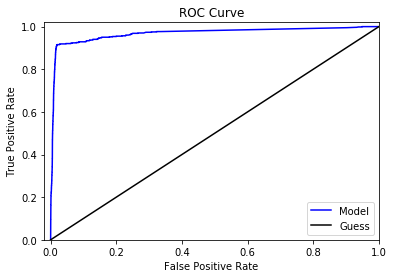

AUC = 0.968



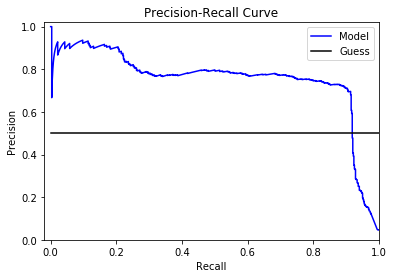

F1 Score = 0.726
MCC = 0.716
AUC for Precision-Recall: 0.753
Average Precision = 0.753


In [37]:
# Level 1 Learner
y_pred = model_lr.predict(x_level_1_test)
y_prob = model_lr.decision_function(x_level_1_test)
metrics = ModelMetrics(y_test,y_pred,y_prob)
metrics.all_metrics()

In [ ]:
model = models_rf[4]
x_test_a = x_test_rf
y_pred = model.predict(x_test_a)
#y_prob = model.decision_function(x_test_a)
y_prob = model.predict_proba(x_test_a)
y_prob = np.max(y_prob,axis=1)

metrics = ModelMetrics(y_test,y_pred,y_prob)
metrics.all_metrics()

In [ ]:
model = models_svm[0]
x_test_a = x_test_svm
y_pred = model.predict(x_test_a)
y_prob = model.decision_function(x_test_a)
#y_prob = model.predict_proba(x_test_a)
#y_prob = np.max(y_prob,axis=1)

metrics = ModelMetrics(y_test,y_pred,y_prob)
metrics.all_metrics()

In [ ]:
model_lda = LinearDiscriminantAnalysis()
model_lda.fit(x_train_lda_k,y_train_k)
model = models_lda[0]
model = model_lda
x_test_a = x_train_lda
y_pred = model.predict(x_test_a)
y_prob = model.decision_function(x_test_a)
#y_prob = model.predict_proba(x_test_a)
#y_prob = np.max(y_prob,axis=1)

metrics = ModelMetrics(y_train,y_pred,y_prob)
metrics.all_metrics()

In [ ]:
x_train_lda_k.shape
x_train_lda.shape

In [10]:
# Different Ensemble that uses RF/LDA and then SVM

In [25]:
# Hyperparameters
# SVM
C = 10 #[0.1,1,10]
C_list = [0.1,1,10]
gamma = 3 #[0.1,0.3,1,3,10]
max_iter = 5000
gamma_list = [0.1,0.3,1,3,10]

# RF
criterion='entropy'
max_depth=9 #range(1,11)
max_depth_list = np.arange(1,11)
n_estimators=100 #[10,50,100]
n_estimators_list = [10,50,100]
min_samples_split=2 #[2,5,10,20]
min_samples_split_list = [2,5,10,20]

# LDA / QDA

# Do k folds to determine level 1 data, 
n_models = 2
n_splits = 30
models_svm = []
models_rf = []
models_lda = []
x_level_1 = np.empty((n_train_index.shape[0],n_models*n_splits))
y_level_1 = np.empty(n_train_index.shape)
y_level_1 = y_train

kf = KFold(n_splits=n_splits,shuffle=True)
fold_count = 0
for ktrain_index, ktest_index in kf.split(y_train):
    print("\nStarting Fold ",fold_count)
    x_train_rf_k, x_test_rf_k = x_train_rf[ktrain_index], x_train_rf[ktest_index]
    x_train_lda_k, x_test_lda_k = x_train_lda[ktrain_index], x_train_lda[ktest_index]
    y_train_k, y_test_k = y_train[ktrain_index], y_train[ktest_index]
    
    # Assign random values to hyperparameters?
    max_depth = random.choice(max_depth_list)
    n_estimators = random.choice(n_estimators_list)
    min_samples_split = random.choice(min_samples_split_list)
    
    # Train RF model k
    model_rf = RandomForestClassifier(criterion = criterion, max_depth = max_depth, n_estimators = n_estimators,
                                      min_samples_split = min_samples_split)
    model_rf.fit(x_train_rf_k,y_train_k)
    #x_rf_1 = model_rf.predict(x_test_rf_k)
    x_rf_1 = model_rf.predict_proba(x_train_rf)[:,1]
    x_level_1[:,n_models*fold_count+0] = x_rf_1
    models_rf.append(model_rf)
    print("Done RF.")
    
    # Train LDA model k
    model_lda = QuadraticDiscriminantAnalysis()
    model_lda.fit(x_train_lda_k,y_train_k)
    #x_lda_1 = model_lda.predict(x_test_lda_k)
    x_lda_1 = model_lda.predict_proba(x_train_lda)[:,1]
    x_level_1[:,n_models*fold_count+1] = x_lda_1
    models_lda.append(model_lda)
    print("Done LDA.\n")
    
    # Make sure y data is in same order as x
    
    fold_count+=1


Starting Fold  0
Done RF.
Done LDA.


Starting Fold  1


C:\Users\linds\Anaconda3\envs\datascience\lib\site-packages\sklearn\discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\linds\Anaconda3\envs\datascience\lib\site-packages\sklearn\discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Done RF.
Done LDA.


Starting Fold  2


C:\Users\linds\Anaconda3\envs\datascience\lib\site-packages\sklearn\discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\linds\Anaconda3\envs\datascience\lib\site-packages\sklearn\discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Done RF.
Done LDA.


Starting Fold  3


C:\Users\linds\Anaconda3\envs\datascience\lib\site-packages\sklearn\discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\linds\Anaconda3\envs\datascience\lib\site-packages\sklearn\discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Done RF.
Done LDA.


C:\Users\linds\Anaconda3\envs\datascience\lib\site-packages\sklearn\discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\linds\Anaconda3\envs\datascience\lib\site-packages\sklearn\discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")




Starting Fold  4
Done RF.
Done LDA.


Starting Fold  5


C:\Users\linds\Anaconda3\envs\datascience\lib\site-packages\sklearn\discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\linds\Anaconda3\envs\datascience\lib\site-packages\sklearn\discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Done RF.
Done LDA.


Starting Fold  6


C:\Users\linds\Anaconda3\envs\datascience\lib\site-packages\sklearn\discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\linds\Anaconda3\envs\datascience\lib\site-packages\sklearn\discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Done RF.


C:\Users\linds\Anaconda3\envs\datascience\lib\site-packages\sklearn\discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\linds\Anaconda3\envs\datascience\lib\site-packages\sklearn\discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Done LDA.


Starting Fold  7
Done RF.
Done LDA.


Starting Fold  8


C:\Users\linds\Anaconda3\envs\datascience\lib\site-packages\sklearn\discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\linds\Anaconda3\envs\datascience\lib\site-packages\sklearn\discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Done RF.
Done LDA.


Starting Fold  9


C:\Users\linds\Anaconda3\envs\datascience\lib\site-packages\sklearn\discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\linds\Anaconda3\envs\datascience\lib\site-packages\sklearn\discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Done RF.
Done LDA.


Starting Fold  10


C:\Users\linds\Anaconda3\envs\datascience\lib\site-packages\sklearn\discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\linds\Anaconda3\envs\datascience\lib\site-packages\sklearn\discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Done RF.
Done LDA.


Starting Fold  11


C:\Users\linds\Anaconda3\envs\datascience\lib\site-packages\sklearn\discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\linds\Anaconda3\envs\datascience\lib\site-packages\sklearn\discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Done RF.
Done LDA.


Starting Fold  12


C:\Users\linds\Anaconda3\envs\datascience\lib\site-packages\sklearn\discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\linds\Anaconda3\envs\datascience\lib\site-packages\sklearn\discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Done RF.
Done LDA.


Starting Fold  13


C:\Users\linds\Anaconda3\envs\datascience\lib\site-packages\sklearn\discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\linds\Anaconda3\envs\datascience\lib\site-packages\sklearn\discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Done RF.
Done LDA.


Starting Fold  14


C:\Users\linds\Anaconda3\envs\datascience\lib\site-packages\sklearn\discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\linds\Anaconda3\envs\datascience\lib\site-packages\sklearn\discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Done RF.
Done LDA.


Starting Fold  15


C:\Users\linds\Anaconda3\envs\datascience\lib\site-packages\sklearn\discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\linds\Anaconda3\envs\datascience\lib\site-packages\sklearn\discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Done RF.
Done LDA.


Starting Fold  16


C:\Users\linds\Anaconda3\envs\datascience\lib\site-packages\sklearn\discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\linds\Anaconda3\envs\datascience\lib\site-packages\sklearn\discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Done RF.
Done LDA.


Starting Fold  17


C:\Users\linds\Anaconda3\envs\datascience\lib\site-packages\sklearn\discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\linds\Anaconda3\envs\datascience\lib\site-packages\sklearn\discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Done RF.
Done LDA.


Starting Fold  18


C:\Users\linds\Anaconda3\envs\datascience\lib\site-packages\sklearn\discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\linds\Anaconda3\envs\datascience\lib\site-packages\sklearn\discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Done RF.
Done LDA.


Starting Fold  19


C:\Users\linds\Anaconda3\envs\datascience\lib\site-packages\sklearn\discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\linds\Anaconda3\envs\datascience\lib\site-packages\sklearn\discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Done RF.
Done LDA.


Starting Fold  20


C:\Users\linds\Anaconda3\envs\datascience\lib\site-packages\sklearn\discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\linds\Anaconda3\envs\datascience\lib\site-packages\sklearn\discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Done RF.
Done LDA.


Starting Fold  21


C:\Users\linds\Anaconda3\envs\datascience\lib\site-packages\sklearn\discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\linds\Anaconda3\envs\datascience\lib\site-packages\sklearn\discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Done RF.
Done LDA.


Starting Fold  22


C:\Users\linds\Anaconda3\envs\datascience\lib\site-packages\sklearn\discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\linds\Anaconda3\envs\datascience\lib\site-packages\sklearn\discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Done RF.
Done LDA.


C:\Users\linds\Anaconda3\envs\datascience\lib\site-packages\sklearn\discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\linds\Anaconda3\envs\datascience\lib\site-packages\sklearn\discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")




Starting Fold  23
Done RF.
Done LDA.


Starting Fold  24


C:\Users\linds\Anaconda3\envs\datascience\lib\site-packages\sklearn\discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\linds\Anaconda3\envs\datascience\lib\site-packages\sklearn\discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Done RF.
Done LDA.


Starting Fold  25


C:\Users\linds\Anaconda3\envs\datascience\lib\site-packages\sklearn\discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\linds\Anaconda3\envs\datascience\lib\site-packages\sklearn\discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Done RF.
Done LDA.


Starting Fold  26


C:\Users\linds\Anaconda3\envs\datascience\lib\site-packages\sklearn\discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\linds\Anaconda3\envs\datascience\lib\site-packages\sklearn\discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Done RF.
Done LDA.


Starting Fold  27


C:\Users\linds\Anaconda3\envs\datascience\lib\site-packages\sklearn\discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\linds\Anaconda3\envs\datascience\lib\site-packages\sklearn\discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Done RF.
Done LDA.


Starting Fold  28


C:\Users\linds\Anaconda3\envs\datascience\lib\site-packages\sklearn\discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\linds\Anaconda3\envs\datascience\lib\site-packages\sklearn\discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Done RF.
Done LDA.


Starting Fold  29


C:\Users\linds\Anaconda3\envs\datascience\lib\site-packages\sklearn\discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\linds\Anaconda3\envs\datascience\lib\site-packages\sklearn\discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Done RF.
Done LDA.



C:\Users\linds\Anaconda3\envs\datascience\lib\site-packages\sklearn\discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\linds\Anaconda3\envs\datascience\lib\site-packages\sklearn\discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [19]:
x_level_1

array([[9.71798866e-04, 1.97554712e-03, 1.47222982e-03, ...,
        2.14529459e-03, 2.44543118e-03, 2.08881571e-03],
       [2.31342173e-03, 6.84495786e-03, 8.01863254e-04, ...,
        7.19038752e-03, 1.55687483e-03, 7.01542209e-03],
       [0.00000000e+00, 2.32150077e-04, 5.03096782e-04, ...,
        2.68607201e-04, 7.51768732e-05, 2.49084053e-04],
       ...,
       [2.53089990e-03, 6.58226417e-03, 5.32002554e-03, ...,
        7.14888110e-03, 7.56882055e-03, 6.83019152e-03],
       [5.97616986e-03, 4.33493346e-02, 1.75544274e-02, ...,
        4.24647162e-02, 4.30757473e-02, 4.33895875e-02],
       [8.22537727e-04, 1.68026907e-02, 6.59574838e-03, ...,
        1.67940385e-02, 1.12105852e-02, 1.69590712e-02]])

In [26]:
# Do logistic regression on the outputs (Level 1 Learner)
model_svm = SVC(gamma='scale')
model_svm.fit(x_level_1,y_level_1)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [27]:
# Do test data
x_level_1_test = np.empty((n_test_index.shape[0],n_models*n_splits))
y_level_1_test = np.empty(n_test_index.shape)

fold_count = 0
for ii in range(n_splits):
    print("\nStarting Fold ",fold_count)
    
    # Train RF model k
    model_rf = models_rf[ii]
    x_rf_1 = model_rf.predict(x_test_rf)
    x_level_1_test[:,n_models*fold_count+0] = x_rf_1
    print("Done RF.")
    
    # Train LDA model k
    model_lda = models_lda[ii]
    x_lda_1 = model_lda.predict(x_test_lda)
    x_level_1_test[:,n_models*fold_count+1] = x_lda_1
    print("Done LDA.\n")
    
    fold_count+=1


Starting Fold  0
Done RF.
Done LDA.


Starting Fold  1
Done RF.
Done LDA.


Starting Fold  2
Done RF.
Done LDA.


Starting Fold  3
Done RF.
Done LDA.


Starting Fold  4
Done RF.
Done LDA.


Starting Fold  5
Done RF.
Done LDA.


Starting Fold  6
Done RF.
Done LDA.


Starting Fold  7
Done RF.
Done LDA.


Starting Fold  8
Done RF.
Done LDA.


Starting Fold  9
Done RF.
Done LDA.


Starting Fold  10
Done RF.
Done LDA.


Starting Fold  11
Done RF.
Done LDA.


Starting Fold  12
Done RF.
Done LDA.


Starting Fold  13
Done RF.
Done LDA.


Starting Fold  14
Done RF.
Done LDA.


Starting Fold  15
Done RF.
Done LDA.


Starting Fold  16
Done RF.
Done LDA.


Starting Fold  17
Done RF.
Done LDA.


Starting Fold  18
Done RF.
Done LDA.


Starting Fold  19
Done RF.
Done LDA.


Starting Fold  20
Done RF.
Done LDA.


Starting Fold  21
Done RF.
Done LDA.


Starting Fold  22
Done RF.
Done LDA.


Starting Fold  23
Done RF.
Done LDA.


Starting Fold  24
Done RF.
Done LDA.


Starting Fold  25
Done RF.
Done LD


Number of -1 cases =  43417
Number of +1 cases =  2002
The ratio of Positve to Negative cases is 0.046

Number of Negative Classes is quite large. Recommend using the Precision-Recall Metrics.


Overall Accuracy = 0.966

           CONFUSION MATRIX
                 y_pred
              -1        1     
           --------------------
y_test -1 |  43348       69    |
        1 |   1456      546    |
           --------------------



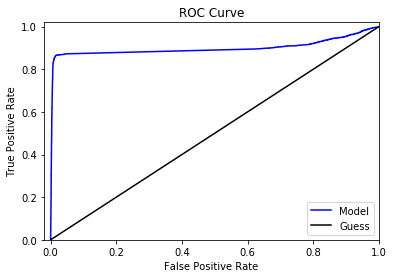

AUC = 0.899



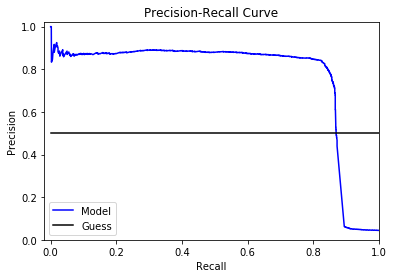

F1 Score = 0.417
MCC = 0.482
AUC for Precision-Recall: 0.769
Average Precision = 0.765


In [28]:
# Level 1 Learner
y_pred = model_svm.predict(x_level_1_test)
y_prob = model_svm.decision_function(x_level_1_test)
metrics = ModelMetrics(y_test,y_pred,y_prob)
metrics.all_metrics()